In this Notebook, we will build a multi-label model that’s capable of detecting different types of toxicity like severe toxic, threats, obscenity, insults, and so on. We will be using supervised classifiers and text representations. A toxic comment might be about any of toxic, severe toxic, obscene, threat, insult or identity hate at the same time or none of the above. The data set can be found at Kaggle [here](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline/data)

In [0]:
import numpy as np
import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
df = pd.read_csv("train.csv", encoding = "ISO-8859-1",engine="python",error_bad_lines=False)
df.head()

In [0]:
df.shape

**Lets see the number of comments in each category**

In [0]:
data=df.drop(["id","comment_text"],axis=1)
counts=[]
categories=list(data.columns.values)
for i in categories:
  counts.append((i, data[i].sum()))
data_stats=pd.DataFrame(counts,columns=["category","number_of_commnets"])
data_stats

Text(0.5, 0, 'category')

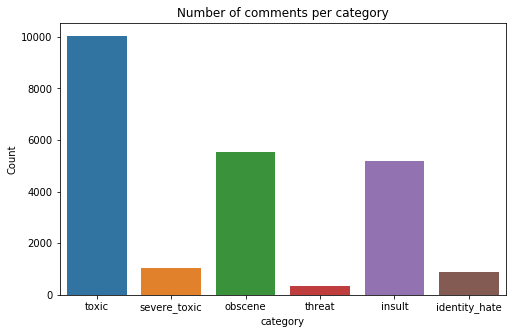

In [32]:

plt.figure(figsize=(8,5))
ax=sns.barplot(data_stats.category,data_stats.number_of_commnets)

plt.title("Number of comments per category")
plt.ylabel("Count")
plt.xlabel("category")

**multi-Label**
How many commnets has multi labels

Text(0.5, 0, '# of categories')

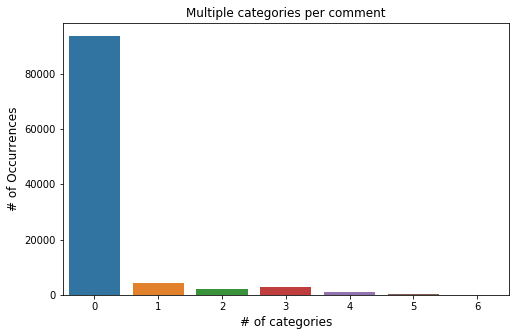

In [28]:
multilabels=df.iloc[:,2:].sum(axis=1)
x=multilabels.value_counts()

plt.figure(figsize=(8,5))
ax=sns.barplot(x.index,x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

The above plot shows that there are more observations without any labels i.e doesnt beong to any categorgy

In [33]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))

Percentage of comments that are not labelled:
0.8979834495191156


Lets see the distribution of the number of words in comment texts

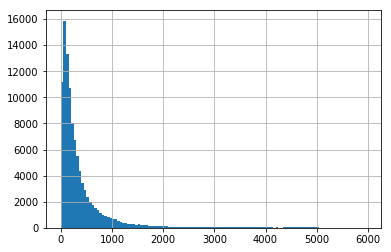

In [38]:
length=df.comment_text.str.len()
length.hist(bins=np.arange(0,6000,50))

Most of the comment text length are within the range of 500 charactors,  with few ranging to 5000 characters long

In [41]:
#misiing rows

print("Missing comment_text rows:",df["comment_text"].isnull().sum())

Missing comment_text rows: 0


In [42]:
#lets look at one comment_text
df["comment_text"][79]

'Hi! I am back again!\nLast warning!\nStop undoing my edits or die!'

The text needs preprocessing, lets clean the text

In [0]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [0]:
df["comment_text"]=df["comment_text"].map(lambda com: clean_text(com))

In [45]:
df["comment_text"][79]

'hi i am back again last warning stop undoing my edits or die'

Now will make training ang testing sets for building model

In [55]:
categories=["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
train,test=train_test_split(df,random_state=42,test_size=0.25,shuffle=True)
X_train=train.comment_text
X_test=test.comment_text
print("train shape:",X_train.shape)
print("test shape:",X_test.shape)

train shape: (78215,)
test shape: (26072,)


**Classifiers Training**
**Pipeline** 

Scikit-learn provides a pipeline utility to help automate machine learning workflows. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply. So we will utilize pipeline to train every classifier.

**One Vs Rest multi-label strategy**

The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample

Lets start with **Naive Bayes**


OneVsRest strategy can be used for multi-label learning, where a classifier is used to predict multiple labels for instance. Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrap Naive Bayes in the OneVsRestClassifier.

In [56]:
import nltk
nltk.download('stopwords')
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
stop_words = set(stopwords.words('english'))
Nb_pipeline=Pipeline([("tfidf",TfidfVectorizer(stop_words=stop_words)),
                     ("clf",OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    Nb_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = Nb_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9205277692543725
... Processing severe_toxic
Test accuracy is 0.9901810371279534
... Processing obscene
Test accuracy is 0.9524393985885241
... Processing threat
Test accuracy is 0.9967781528076097
... Processing insult
Test accuracy is 0.9526311752071187
... Processing identity_hate
Test accuracy is 0.9916001841055538


Lets see **LinearSVC**

In [59]:
from sklearn.svm import LinearSVC
Lsvc_pipeline=Pipeline([("tfidf",TfidfVectorizer(stop_words=stop_words)),
                     ("clf",OneVsRestClassifier(LinearSVC(),n_jobs=1))])

for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    Lsvc_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = Lsvc_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9595351334765265
... Processing severe_toxic
Test accuracy is 0.9901043264805155
... Processing obscene
Test accuracy is 0.9786744400122737
... Processing threat
Test accuracy is 0.9972767720159558
... Processing insult
Test accuracy is 0.9709650199447684
... Processing identity_hate
Test accuracy is 0.9922905799324946


Lets go to **Logostic Regression**

In [60]:
from sklearn.linear_model import LogisticRegression
Log_pipeline=Pipeline([("tfidf",TfidfVectorizer(stop_words=stop_words)),
                     ("clf",OneVsRestClassifier(LogisticRegression(solver="sag"),n_jobs=1))])

for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    Log_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = Log_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9522859772936484
... Processing severe_toxic
Test accuracy is 0.9907180116600184
... Processing obscene
Test accuracy is 0.9761813439705431
... Processing threat
Test accuracy is 0.9970849953973612
... Processing insult
Test accuracy is 0.9688171218165081
... Processing identity_hate
Test accuracy is 0.9917919607241485


As we see all the results are pretty much similar, which tells that the baseline was pretty good, We can build advanced models using n-grams to make models more generalized.